In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,recall_score, auc, roc_curve,precision_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
### The bining and WOE encode ALG called from ready-made library ###
import variable_bin_methods as varbin_meth
import variable_encode as var_encode

In [3]:
os.path.abspath('.')

'C:\\Users\\xsask\\JupyterLab\\XAI\\XAI_GermanCredit'

In [4]:
# data preprocessing ###
def data_read(data_path,file_name):
    df = pd.read_csv( os.path.join(data_path, file_name), delim_whitespace = True, header = None )
    columns = ['status_account','duration','credit_history','purpose', 'amount',
               'svaing_account', 'present_emp', 'income_rate', 'personal_status',
               'other_debtors', 'residence_info', 'property', 'age',
               'inst_plans', 'housing', 'num_credits',
               'job', 'dependents', 'telephone', 'foreign_worker', 'target']
    df.columns = columns
    
    # Change label from 1,2 to 0,1(0 means good credit, 1 means bad credit)
    df.target = df.target - 1
    
    
    # Split dataset
    data_train, data_test = train_test_split(df, test_size=0.2, random_state=0,stratify=df.target) 
    data_train = data_train.reset_index(drop=True)
    data_test = data_test.reset_index(drop=True)
    return data_train, data_test

if __name__ == '__main__':
    data_path = os.path.join('C:\\Users\\xsask\\JupyterLab\\XAI','XAI_GermanCredit')
    file_name = 'german.data'
    data_train, data_test = data_read(data_path,file_name)

In [5]:
data_train.info()
print('traget=0(Good credit)  in data_train：',sum(data_train.target ==0))
print('traget=1(bad credit)  in data_train：',sum(data_train.target ==1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   status_account   800 non-null    object
 1   duration         800 non-null    int64 
 2   credit_history   800 non-null    object
 3   purpose          800 non-null    object
 4   amount           800 non-null    int64 
 5   svaing_account   800 non-null    object
 6   present_emp      800 non-null    object
 7   income_rate      800 non-null    int64 
 8   personal_status  800 non-null    object
 9   other_debtors    800 non-null    object
 10  residence_info   800 non-null    int64 
 11  property         800 non-null    object
 12  age              800 non-null    int64 
 13  inst_plans       800 non-null    object
 14  housing          800 non-null    object
 15  num_credits      800 non-null    int64 
 16  job              800 non-null    object
 17  dependents       800 non-null    in

In [6]:
### Distinguish discrete/continuous variables ###
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
        
    # If int or float then distinguish directly as continuous variables
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float',
                                                                  'int32','float32',
                                                                  'int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var

In [7]:
feature_names = list(data_train.columns)
feature_names.remove('target')
categorical_var,numerical_var = category_continue_separation(data_train,feature_names)
print('Initialize 7 continous variables：','\n',numerical_var)
print('='*80)
print('Initial continuous variable：')
for s in set(numerical_var):
    print('variable '+s+' possible value'+str(len(data_train[s].unique())))
    if len(data_train[s].unique())<=10:
        categorical_var.append(s)
        numerical_var.remove(s)
        index_1 = data_train[s].isnull()     
        if sum(index_1) > 0:
            data_train.loc[~index_1,s] = data_train.loc[~index_1,s].astype('str')   
        else:
            data_train[s] = data_train[s].astype('str')
        index_2 = data_test[s].isnull()
        if sum(index_2) > 0:
            data_test.loc[~index_2,s] = data_test.loc[~index_2,s].astype('str')
        else:
            data_test[s] = data_test[s].astype('str')

print('='*80)
print('Remaining continous variables：','\n',numerical_var)
print('='*80)
print('Discrete variables：','\n',categorical_var)

Initialize 7 continous variables： 
 ['duration', 'amount', 'income_rate', 'residence_info', 'age', 'num_credits', 'dependents']
Initial continuous variable：
variable num_credits possible value4
variable amount possible value744
variable income_rate possible value4
variable residence_info possible value4
variable age possible value53
variable dependents possible value2
variable duration possible value30
Remaining continous variables： 
 ['duration', 'amount', 'age']
Discrete variables： 
 ['status_account', 'credit_history', 'purpose', 'svaing_account', 'present_emp', 'personal_status', 'other_debtors', 'property', 'inst_plans', 'housing', 'job', 'telephone', 'foreign_worker', 'num_credits', 'income_rate', 'residence_info', 'dependents']


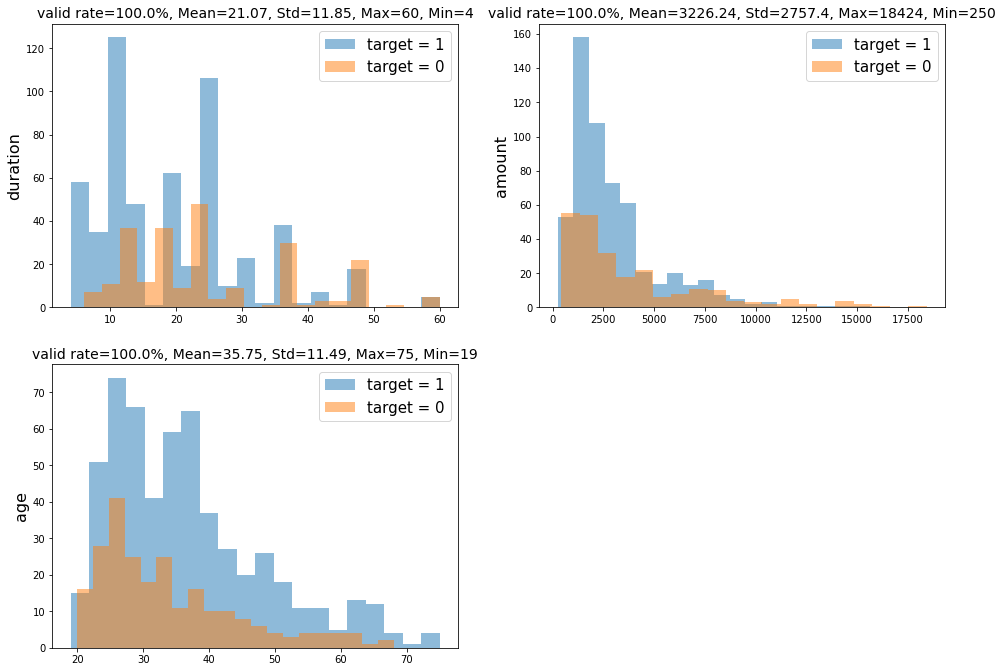

In [8]:
### Continous variables distribution in different category ###
j=1
plt.figure(figsize=(16,24)) 
for i in numerical_var:
    
    df_temp = data_train.loc[~data_train[i].isnull(),[i,'target']]
    df_good = df_temp[df_temp.target == 0]
    df_bad = df_temp[df_temp.target == 1]
    
    valid = round(df_temp.shape[0]/data_train.shape[0]*100,2)
    Mean = round(df_temp[i].mean(),2) 
    Std = round(df_temp[i].std(),2)
    Max = round(df_temp[i].max(),2)
    Min = round(df_temp[i].min(),2)
    
    plt.subplot(4,2,j)
    plt.hist(df_good[i],bins =20, alpha=0.5,label='target = 1')
    plt.hist(df_bad[i],bins =20, alpha=0.5,label='target = 0')
    plt.ylabel(i,fontsize=16)
    plt.title( 'valid rate='+str(valid)+'%, Mean='+str(Mean) + ', Std='+str(Std)+', Max='+str(Max)+', Min='+str(Min),fontsize=14)
    plt.legend(fontsize=15)
    j=j+1

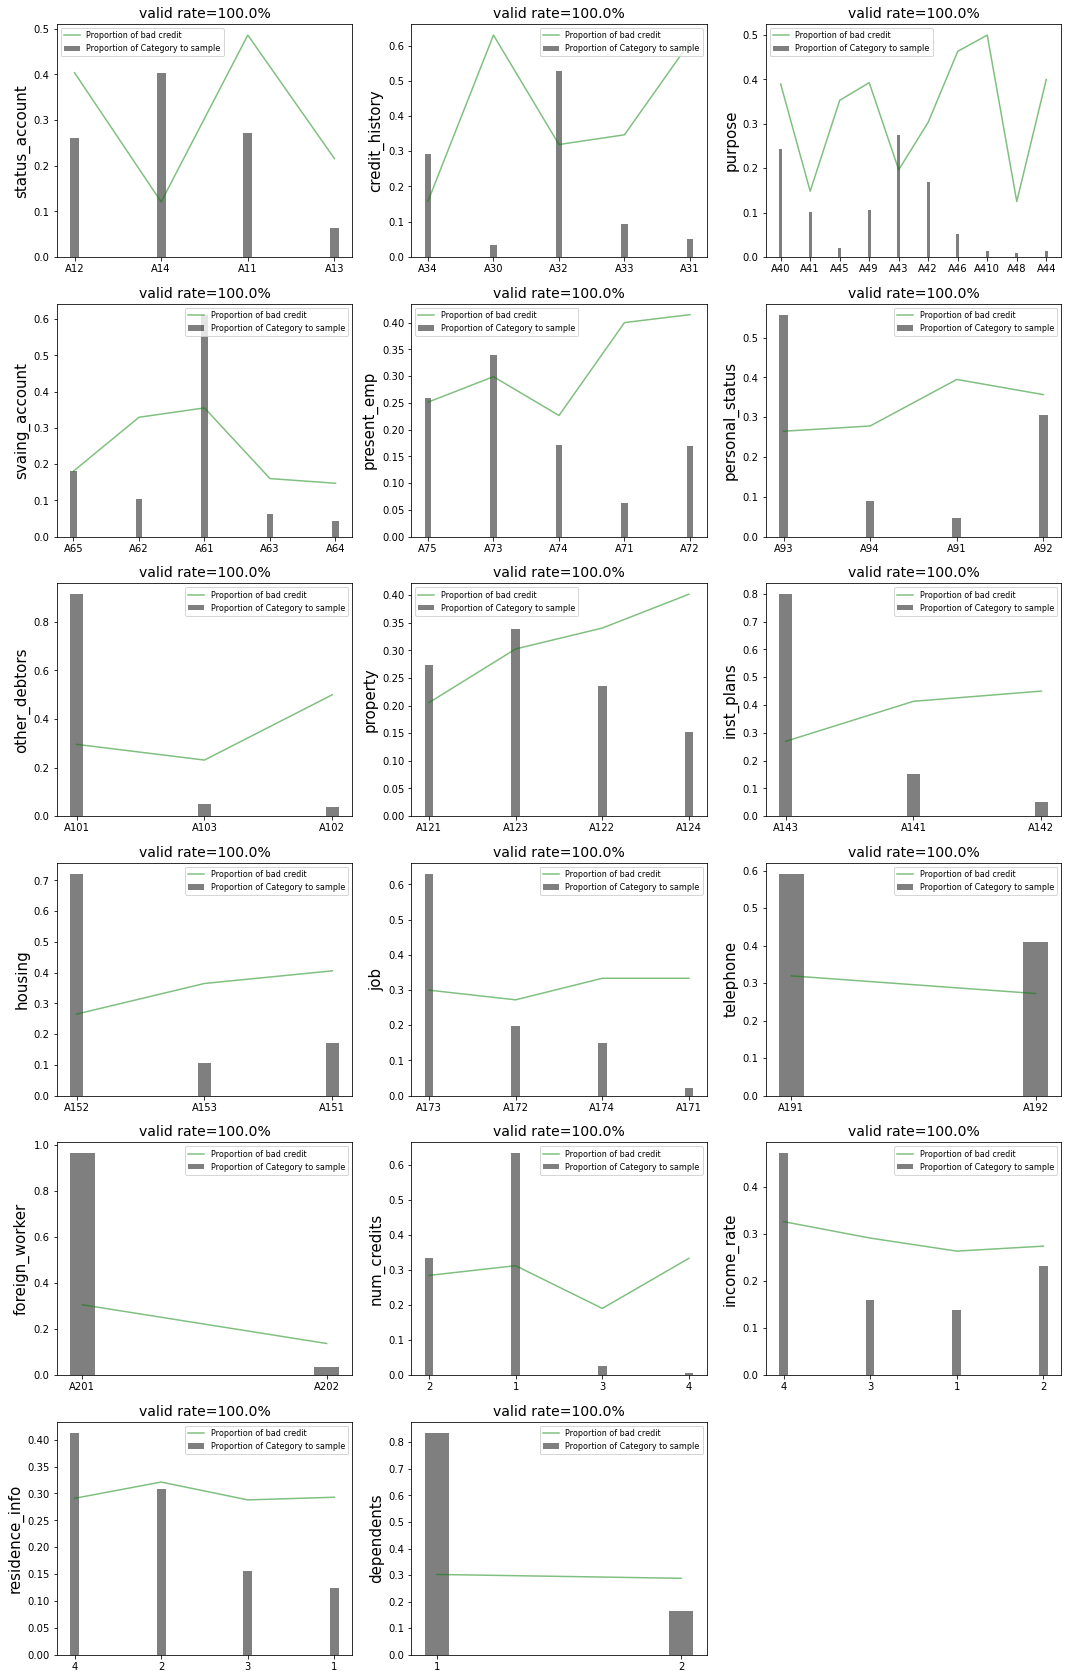

In [9]:
### Continous variables distribution in different category ###
k=1
plt.figure(figsize=(18,30)) 
for i in categorical_var:
    
    df_temp = data_train.loc[~data_train[i].isnull(),[i,'target']]
    df_bad = df_temp[df_temp.target == 1]
    valid = round(df_temp.shape[0]/data_train.shape[0]*100,2)
    bad_rate = []
    bin_rate = []
    var_name = []
    for j in data_train[i].unique():         
        if pd.isnull(j):
            df_1 = data_train[data_train[i].isnull()]
            bad_rate.append(sum(df_1.target)/df_1.shape[0])
            bin_rate.append(df_1.shape[0]/data_train.shape[0])
            var_name.append('NA')
        else:
            df_1 = data_train[data_train[i] == j]
            bad_rate.append(sum(df_1.target)/df_1.shape[0])
            bin_rate.append(df_1.shape[0]/data_train.shape[0])
            var_name.append(j)
    df_2 = pd.DataFrame({'var_name':var_name,'bin_rate':bin_rate,'bad_rate':bad_rate})
   
    plt.subplot(6,3,k)
    plt.bar(np.arange(1,df_2.shape[0]+1),df_2.bin_rate,0.1,color='black',alpha=0.5, label='Proportion of Category to sample')
    plt.xticks(np.arange(1,df_2.shape[0]+1), df_2.var_name)
    plt.plot( np.arange(1,df_2.shape[0]+1),df_2.bad_rate,  color='green', alpha=0.5,label='Proportion of bad credit')   
    plt.ylabel(i,fontsize=15)
    plt.title( 'valid rate='+str(valid)+'%',fontsize=14)
    plt.legend(fontsize=8)
    k=k+1

In [10]:
### data binning ### 

# continous variables binning
dict_cont_bin = {}
for i in numerical_var:
    dict_cont_bin[i],gain_value_save , gain_rate_save = varbin_meth.cont_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3, mmax=12,
                                     bin_rate=0.01, stop_limit=0.05, bin_min_num=20)

# disrecte variables binning
dict_disc_bin = {}
del_key = []
for i in categorical_var:
    dict_disc_bin[i],gain_value_save , gain_rate_save ,del_key_1 = varbin_meth.disc_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3,
                                     mmax=8, stop_limit=0.05, bin_min_num=20)
    if len(del_key_1)>0 :
        del_key.extend(del_key_1)

if len(del_key) > 0:
    for j in del_key:
        del dict_disc_bin[j]
        
print('Delete variable with one single binning：',len(del_key))
print(del_key)

### training data binning

# continous variables binning mapping
df_cont_bin_train = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_train = pd.concat([ df_cont_bin_train , 
                                   varbin_meth.cont_var_bin_map(data_train[i], 
                                   dict_cont_bin[i]) ], axis = 1)

# disrecte variables binning mapping
#    ss = data_train[list( dict_disc_bin.keys())]
df_disc_bin_train = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_train = pd.concat([ df_disc_bin_train , 
                                   varbin_meth.disc_var_bin_map(data_train[i], 
                                   dict_disc_bin[i]) ], axis = 1)

### test data binning

# continous variables binning mapping
df_cont_bin_test = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_test = pd.concat([ df_cont_bin_test , 
                                varbin_meth.cont_var_bin_map(data_test[i], 
                                dict_cont_bin[i]) ], axis = 1)

# disrecte variables binning mapping
#    ss = data_test[list( dict_disc_bin.keys())]
df_disc_bin_test = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_test = pd.concat([ df_disc_bin_test , 
                                  varbin_meth.disc_var_bin_map(data_test[i], 
                                  dict_disc_bin[i]) ], axis = 1)

### composition of training and test data after binning
df_disc_bin_train['target'] = data_train.target
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
df_disc_bin_test['target'] = data_test.target
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

print('='*80)
print('The rest 18 variables of train_data binning results:')
data_train_bin

Delete variable with one single binning： 2
['other_debtors', 'foreign_worker']
The rest 18 variables of train_data binning results:


,duration_BIN,amount_BIN,age_BIN,status_account_BIN,credit_history_BIN,purpose_BIN,svaing_account_BIN,present_emp_BIN,personal_status_BIN,property_BIN,inst_plans_BIN,housing_BIN,job_BIN,telephone_BIN,num_credits_BIN,income_rate_BIN,residence_info_BIN,dependents_BIN,target
0,5,2,7,2,1,4,1,2,1,1,1,1,2,2,1,4,2,2,0
1,5,5,5,2,4,2,2,2,2,2,2,1,2,1,1,3,2,2,0
2,5,2,6,1,1,4,3,3,2,1,1,1,2,1,1,4,4,2,0
3,6,2,3,1,4,4,3,3,1,2,1,1,2,2,1,4,4,2,0
4,2,1,10,3,1,4,3,2,1,1,1,1,1,2,1,4,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,3,2,3,2,1,4,1,3,1,2,2,1,2,2,2,2,2,2,0
796,2,2,3,3,2,4,3,4,1,4,1,2,3,1,2,3,4,2,1
797,3,2,8,1,1,2,1,2,2,1,1,1,2,1,1,4,4,2,0
798,5,3,1,2,1,3,1,2,1,4,1,3,2,2,1,4,2,2,0


In [11]:
### WOE encode ###

# WOE encode
var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')

# training data WOE encode
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,data_path,
                                var_all_bin, data_train_bin.target,'dict_woe_map', flag='train')

# test data WOE encode
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,data_path,var_all_bin, 
                                                  data_test_bin.target, 'dict_woe_map',flag='test')

print('Train_data WOE encode:')
df_train_woe[var_woe_name]

Train_data WOE encode:


,duration_BIN_woe,amount_BIN_woe,age_BIN_woe,status_account_BIN_woe,credit_history_BIN_woe,purpose_BIN_woe,svaing_account_BIN_woe,present_emp_BIN_woe,personal_status_BIN_woe,property_BIN_woe,inst_plans_BIN_woe,housing_BIN_woe,job_BIN_woe,telephone_BIN_woe,num_credits_BIN_woe,income_rate_BIN_woe,residence_info_BIN_woe,dependents_BIN_woe
0,-0.010152,-0.254159,-0.762140,0.301308,-0.824988,0.393733,-0.730888,-0.244884,-0.175031,-0.505095,-0.151537,-0.171998,-0.001890,0.090026,-0.108214,0.122148,-0.043675,0.01138
1,-0.010152,-0.538997,-0.123481,0.301308,1.326871,-0.656780,0.135802,-0.244884,0.204582,0.012270,0.534206,-0.171998,-0.001890,-0.136336,-0.108214,-0.041594,-0.043675,0.01138
2,-0.010152,-0.254159,0.211309,-1.138115,-0.824988,0.393733,0.250611,-0.005277,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336,-0.108214,0.122148,0.098752,0.01138
3,0.746493,-0.254159,-0.060259,-1.138115,1.326871,0.393733,0.250611,-0.005277,-0.175031,0.012270,-0.151537,-0.171998,-0.001890,0.090026,-0.108214,0.122148,0.098752,0.01138
4,-0.762140,0.431137,-0.370098,0.792238,-0.824988,0.393733,0.250611,-0.244884,-0.175031,-0.505095,-0.151537,-0.171998,-0.136434,0.090026,-0.108214,0.122148,-0.043675,0.01138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.311939,-0.254159,-0.060259,0.301308,-0.824988,0.393733,-0.730888,-0.005277,-0.175031,0.012270,0.534206,-0.171998,-0.001890,0.090026,0.058841,-0.126151,-0.043675,0.01138
796,-0.762140,-0.254159,-0.060259,0.792238,0.089612,0.393733,0.250611,0.486683,-0.175031,0.448659,-0.151537,0.292301,0.154151,-0.136336,0.058841,-0.041594,0.098752,0.01138
797,-0.311939,-0.254159,-0.405465,-1.138115,-0.824988,-0.656780,-0.730888,-0.244884,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336,-0.108214,0.122148,0.098752,0.01138
798,-0.010152,-0.604954,0.441833,0.301308,-0.824988,0.017575,-0.730888,-0.244884,-0.175031,0.448659,-0.151537,0.465930,-0.001890,0.090026,-0.108214,0.122148,-0.043675,0.01138


In [12]:
print('Check IV value in train_data：18')
dict_iv_values

Check IV value in train_data：18


{'duration_BIN': 0.2918595066690165,
 'amount_BIN': 0.20572272141009934,
 'age_BIN': 0.15957676538559773,
 'status_account_BIN': 0.6147282330257565,
 'credit_history_BIN': 0.34240107311849893,
 'purpose_BIN': 0.24319295137678967,
 'svaing_account_BIN': 0.1701220951925,
 'present_emp_BIN': 0.09709327722537278,
 'personal_status_BIN': 0.03570166654981978,
 'property_BIN': 0.10381105880538871,
 'inst_plans_BIN': 0.08041152952203817,
 'housing_BIN': 0.07063923377032309,
 'job_BIN': 0.0077963182690151895,
 'telephone_BIN': 0.012261307240533585,
 'num_credits_BIN': 0.006363965130025382,
 'income_rate_BIN': 0.0153569405138668,
 'residence_info_BIN': 0.004494020924339555,
 'dependents_BIN': 0.000664673198277874}

In [13]:
x_train = df_train_woe[var_woe_name]
x_train = np.array(x_train)
y_train = np.array(data_train_bin.target)
    
x_test = df_test_woe[var_woe_name]
x_test = np.array(x_test)
y_test = np.array(data_test_bin.target)

In [14]:
### Build logistic regression model ###

lr_param = {'C': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2],
            'class_weight': [{1: 1, 0: 1}, {1: 2, 0: 1}, {1: 3, 0: 1}]}

lr_gsearch = GridSearchCV(
  estimator=LogisticRegression(random_state=0, fit_intercept=True, penalty='l2', solver='saga'),
  param_grid=lr_param, cv=3, scoring='f1', n_jobs=-1, verbose=2)

#Perform hyperparameter optimization
lr_gsearch.fit(x_train, y_train)
print('logistic model best_score_ is {0},and best_params_ is {1}'.format(lr_gsearch.best_score_,
                                                                            lr_gsearch.best_params_))

Fitting 3 folds for each of 21 candidates, totalling 63 fits
logistic model best_score_ is 0.6502502330113034,and best_params_ is {'C': 1, 'class_weight': {1: 3, 0: 1}}


In [15]:
# Initialize LR 
LR_model_2 = LogisticRegression(C=lr_gsearch.best_params_['C'], penalty='l2', solver='saga',
                                class_weight=lr_gsearch.best_params_['class_weight'])

# Train LR
LR_model_fit = LR_model_2.fit(x_train, y_train)

In [16]:
# model predict
y_pred = LR_model_fit.predict(x_test)
print('PREDICT：')
print('='*80)
print(y_pred)

PREDICT：
[1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0
 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0
 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1
 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0]


In [17]:
### caculate confusion matrix,recall, precision, accuracy

cnf_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred),
                          columns=['Predict True','Predict False'],index=['Real True','Real False'])

recall_value = recall_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print('Recall：',recall_value)
print('Precission：',precision_value)
print('ACC:',acc)
print('='*80)
print('Test cnf_matrix：')
cnf_matrix

Recall： 0.7333333333333333
Precission： 0.4943820224719101
ACC: 0.695
Test cnf_matrix：


,Predict True,Predict False
Real True,95,45
Real False,16,44


In [18]:
### visualization ###
y_score_train = LR_model_fit.predict_proba(x_train)[:, 1]
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
train_precision, train_recall, _ = precision_recall_curve(y_train, y_score_train)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_score_test)

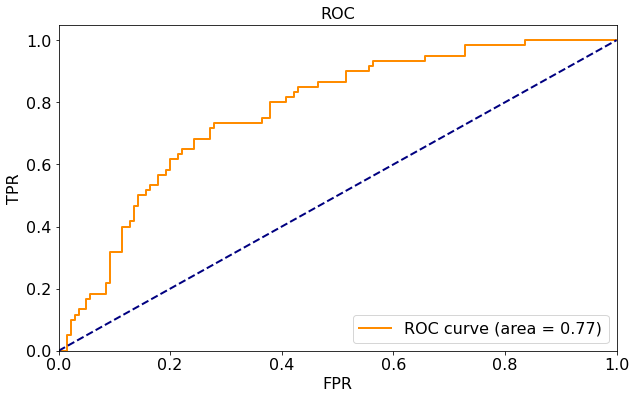

In [19]:
#  FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)

#  AUC 
roc_auc = auc(fpr, tpr)
ar = 2*roc_auc-1
gini = ar


plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('FPR',fontsize=16)
plt.ylabel('TPR',fontsize=16)
plt.title('ROC',fontsize=16)
plt.legend(loc="lower right",fontsize=16)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

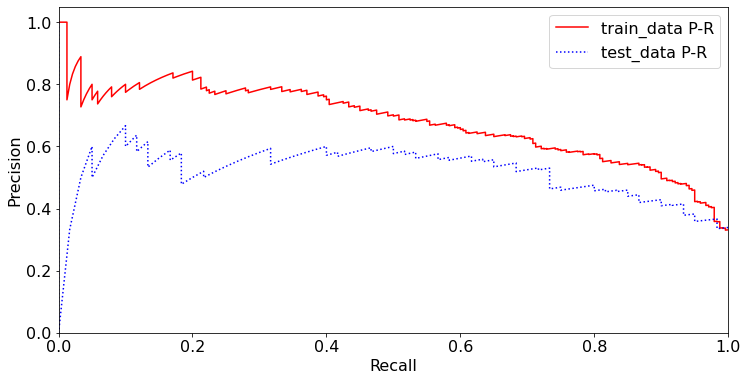

In [20]:
plt.figure(figsize=(12,6))  
plt.plot(train_recall, train_precision,color = 'r', linestyle='-',label='train_data P-R')
plt.plot(test_recall, test_precision,color = 'b', linestyle=':',label='test_data P-R')
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.legend(fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)